In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt

def printMetrics(clf_name, y_pred, y_test, duration):
            print(f"{clf_name}:")
            print(f"Duration: {duration}")
            print(f"Accuracy: {accuracy_score(y_pred, y_test)}")
            print(f"Precision: {precision_score(y_pred, y_test)}")
            print(f"Recall: {recall_score(y_pred, y_test)}")
            print(f"F1: {f1_score(y_pred, y_test)}")
            print(f"Confusion Matrix: {confusion_matrix(y_pred, y_test)}\n\n")

perf_data = {}
metrics = {"Accuracy":accuracy_score,
           "Precision":precision_score,
           "Recall":recall_score,
           "F1":f1_score
           }

results = {}

def calcMetrics(perf_data, metrics):
    for clf, perf_list in perf_data.items():
        results.setdefault(clf, {})
        #print(f"\n{clf}")
        for y_pred, y_test, duration in perf_list:
            results[clf].setdefault("Duration", []).append(duration)
            results[clf].setdefault("Confusion Matrix", []).append(confusion_matrix(y_pred, y_test))
            #print(f"Duration: {duration}")
            for metric_name, metric_func in metrics.items():
                result = metric_func(y_test, y_pred)  # Note the order: y_test, y_pred
                results[clf].setdefault(metric_name, []).append(float(result))
                #print(f"{metric_name}: {result}")
                
def unpackMetrics(results):
    for clf_name, metrics in results.items():
        print(f"\nClassifier: {clf_name}")
        for metric_name, values in metrics.items():
            if metric_name == "Confusion Matrix":
                avg_conf_matrix = np.mean(values, axis=0)
                print(f"Average {metric_name}: \n{avg_conf_matrix}")
            else:
                avg_value = np.mean(values)
                print(f"Average {metric_name}: {avg_value:.4f}")
        
def savePerfData(clf_name, y_pred, y_test, duration):
    perf_data.setdefault(clf_name, []).append((y_pred, y_test, duration))
    #perf_data[clf_name].append(y_pred, y_test, duration)

class StackingClassifier:
    def __init__(self, estimators, final_estimator):
        self.estimators = estimators
        self.final_estimator = final_estimator
    
    def fit(self, X, y):
        # Split the training data into subsets for base and meta training
        X_base, X_meta, y_base, y_meta = train_test_split(X, y, test_size=0.3)
        
        # Train base classifiers on the base training set
        self.base_predictions = []
        for clf_name, clf in self.estimators:
            clf.fit(X_base, y_base)
            base_pred = clf.predict(X_meta)
            self.base_predictions.append(base_pred)
        
        # Prepare input for the meta-learner (using base predictions as features)
        meta_X = np.column_stack(self.base_predictions)
        
        # Train the meta-learner on the meta training set
        self.final_estimator.fit(meta_X, y_meta)
    
    # y_test parameter used for t
    def predict(self, X, y_test):
        # Generate base predictions for the test set
        test_base_predictions = []
        
        for clf_name, clf in self.estimators:
            clf_t_start = time.perf_counter()
            base_pred = clf.predict(X)
            clf_t_end = time.perf_counter()
            clf_t_duration = clf_t_end - clf_t_start
            printMetrics(clf_name, base_pred, y_test, clf_t_duration)
            savePerfData(clf_name, base_pred, y_test, clf_t_duration)
            test_base_predictions.append(base_pred)
        
        # Prepare input for the meta-learner (using base predictions as features)
        test_meta_X = np.column_stack(test_base_predictions)
        
        # Use the meta-learner to make final predictions
        return self.final_estimator.predict(test_meta_X)
    

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv('adult.csv')

# Drop unbalanced columns, duplicates and records with missing values
df.drop(labels=["native.country", "capital.gain", 'capital.loss'], inplace=True, axis=1)
df[df == '?'] = np.nan
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.info()

# Map output label to integer values
df["income"] = df["income"].map({">50K" : 1, "<=50K" : 0})

# Encode categorical data to corresponding integer values
text_cols = ["workclass", "education", "marital.status", "occupation", "relationship", "race", "sex"]
encoder = preprocessing.LabelEncoder()
for col in text_cols:
    df[col] = encoder.fit_transform(df[col])
    
# Scaling data to values in <0, 1> range
scaler = MinMaxScaler()
scaler.fit(df)
df_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
    
y = df.pop('income')
X = df
y_sc = df_scaled.pop('income')
X_sc = df_scaled

<class 'pandas.core.frame.DataFrame'>
Index: 30691 entries, 1 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30691 non-null  int64 
 1   workclass       30691 non-null  object
 2   fnlwgt          30691 non-null  int64 
 3   education       30691 non-null  object
 4   education.num   30691 non-null  int64 
 5   marital.status  30691 non-null  object
 6   occupation      30691 non-null  object
 7   relationship    30691 non-null  object
 8   race            30691 non-null  object
 9   sex             30691 non-null  object
 10  hours.per.week  30691 non-null  int64 
 11  income          30691 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.0+ MB


In [13]:
# Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=int(10_000*.2), train_size=int(10_000*.8))
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

# Define base classifiers
estimators = [
    
    ('GaussianNB', GaussianNB()),  # Gaussian Naive Bayes classifier
    #('BernoulliNB', BernoulliNB()),
    #('ComplementNB', ComplementNB()),
    ('KNN', KNeighborsClassifier(n_neighbors=6, n_jobs=-1)),  # KNN classifier
    ('SVC', SVC())  # Support Vector Classification
]

# Define final estimator (Logistic Regression)
final_estimator = LogisticRegression()

# Create stacking classifier
stacking_clf = StackingClassifier(estimators, final_estimator)

for i in range(5):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_sc,y_sc, test_size=int(30_000*.2), train_size=int(30_000*.8))
    
    # Train the stacking classifier
    stacking_clf.fit(X_train, y_train)
    
    # Evaluate on test set
    stacking_clf_start_time = time.perf_counter()
    y_pred = stacking_clf.predict(X_test, y_test)
    stacking_clf_end_time = time.perf_counter()
    stacking_clf_duration = stacking_clf_end_time - stacking_clf_start_time
    printMetrics("Stacking Classifier", y_pred, y_test, stacking_clf_duration)
    savePerfData("Stacking Classifier", y_pred, y_test, stacking_clf_duration)

    

calcMetrics(perf_data, metrics)
#test
unpackMetrics(results)


GaussianNB:
Duration: 0.0017517000087536871
Accuracy: 0.7716666666666666
Precision: 0.6936997319034852
Recall: 0.5313141683778234
F1: 0.6017441860465116
Confusion Matrix: [[3595  457]
 [ 913 1035]]

KNN:
Duration: 0.3612568999960786
Accuracy: 0.8161666666666667
Precision: 0.49195710455764075
Recall: 0.680259499536608
F1: 0.5709840528977052
Confusion Matrix: [[4163  758]
 [ 345  734]]

SVC:
Duration: 3.3870784000027925
Accuracy: 0.8196666666666667
Precision: 0.4651474530831099
Recall: 0.7096114519427403
F1: 0.5619433198380567
Confusion Matrix: [[4224  798]
 [ 284  694]]


Stacking Classifier:
Duration: 3.7986703000060515
Accuracy: 0.8215
Precision: 0.5428954423592494
Recall: 0.6755629691409508
F1: 0.6020066889632107
Confusion Matrix: [[4119  682]
 [ 389  810]]

GaussianNB:
Duration: 0.001371499995002523
Accuracy: 0.7656666666666667
Precision: 0.6944818304172274
Recall: 0.5201612903225806
F1: 0.5948126801152738
Confusion Matrix: [[3562  454]
 [ 952 1032]]

KNN:
Duration: 0.34845999999379

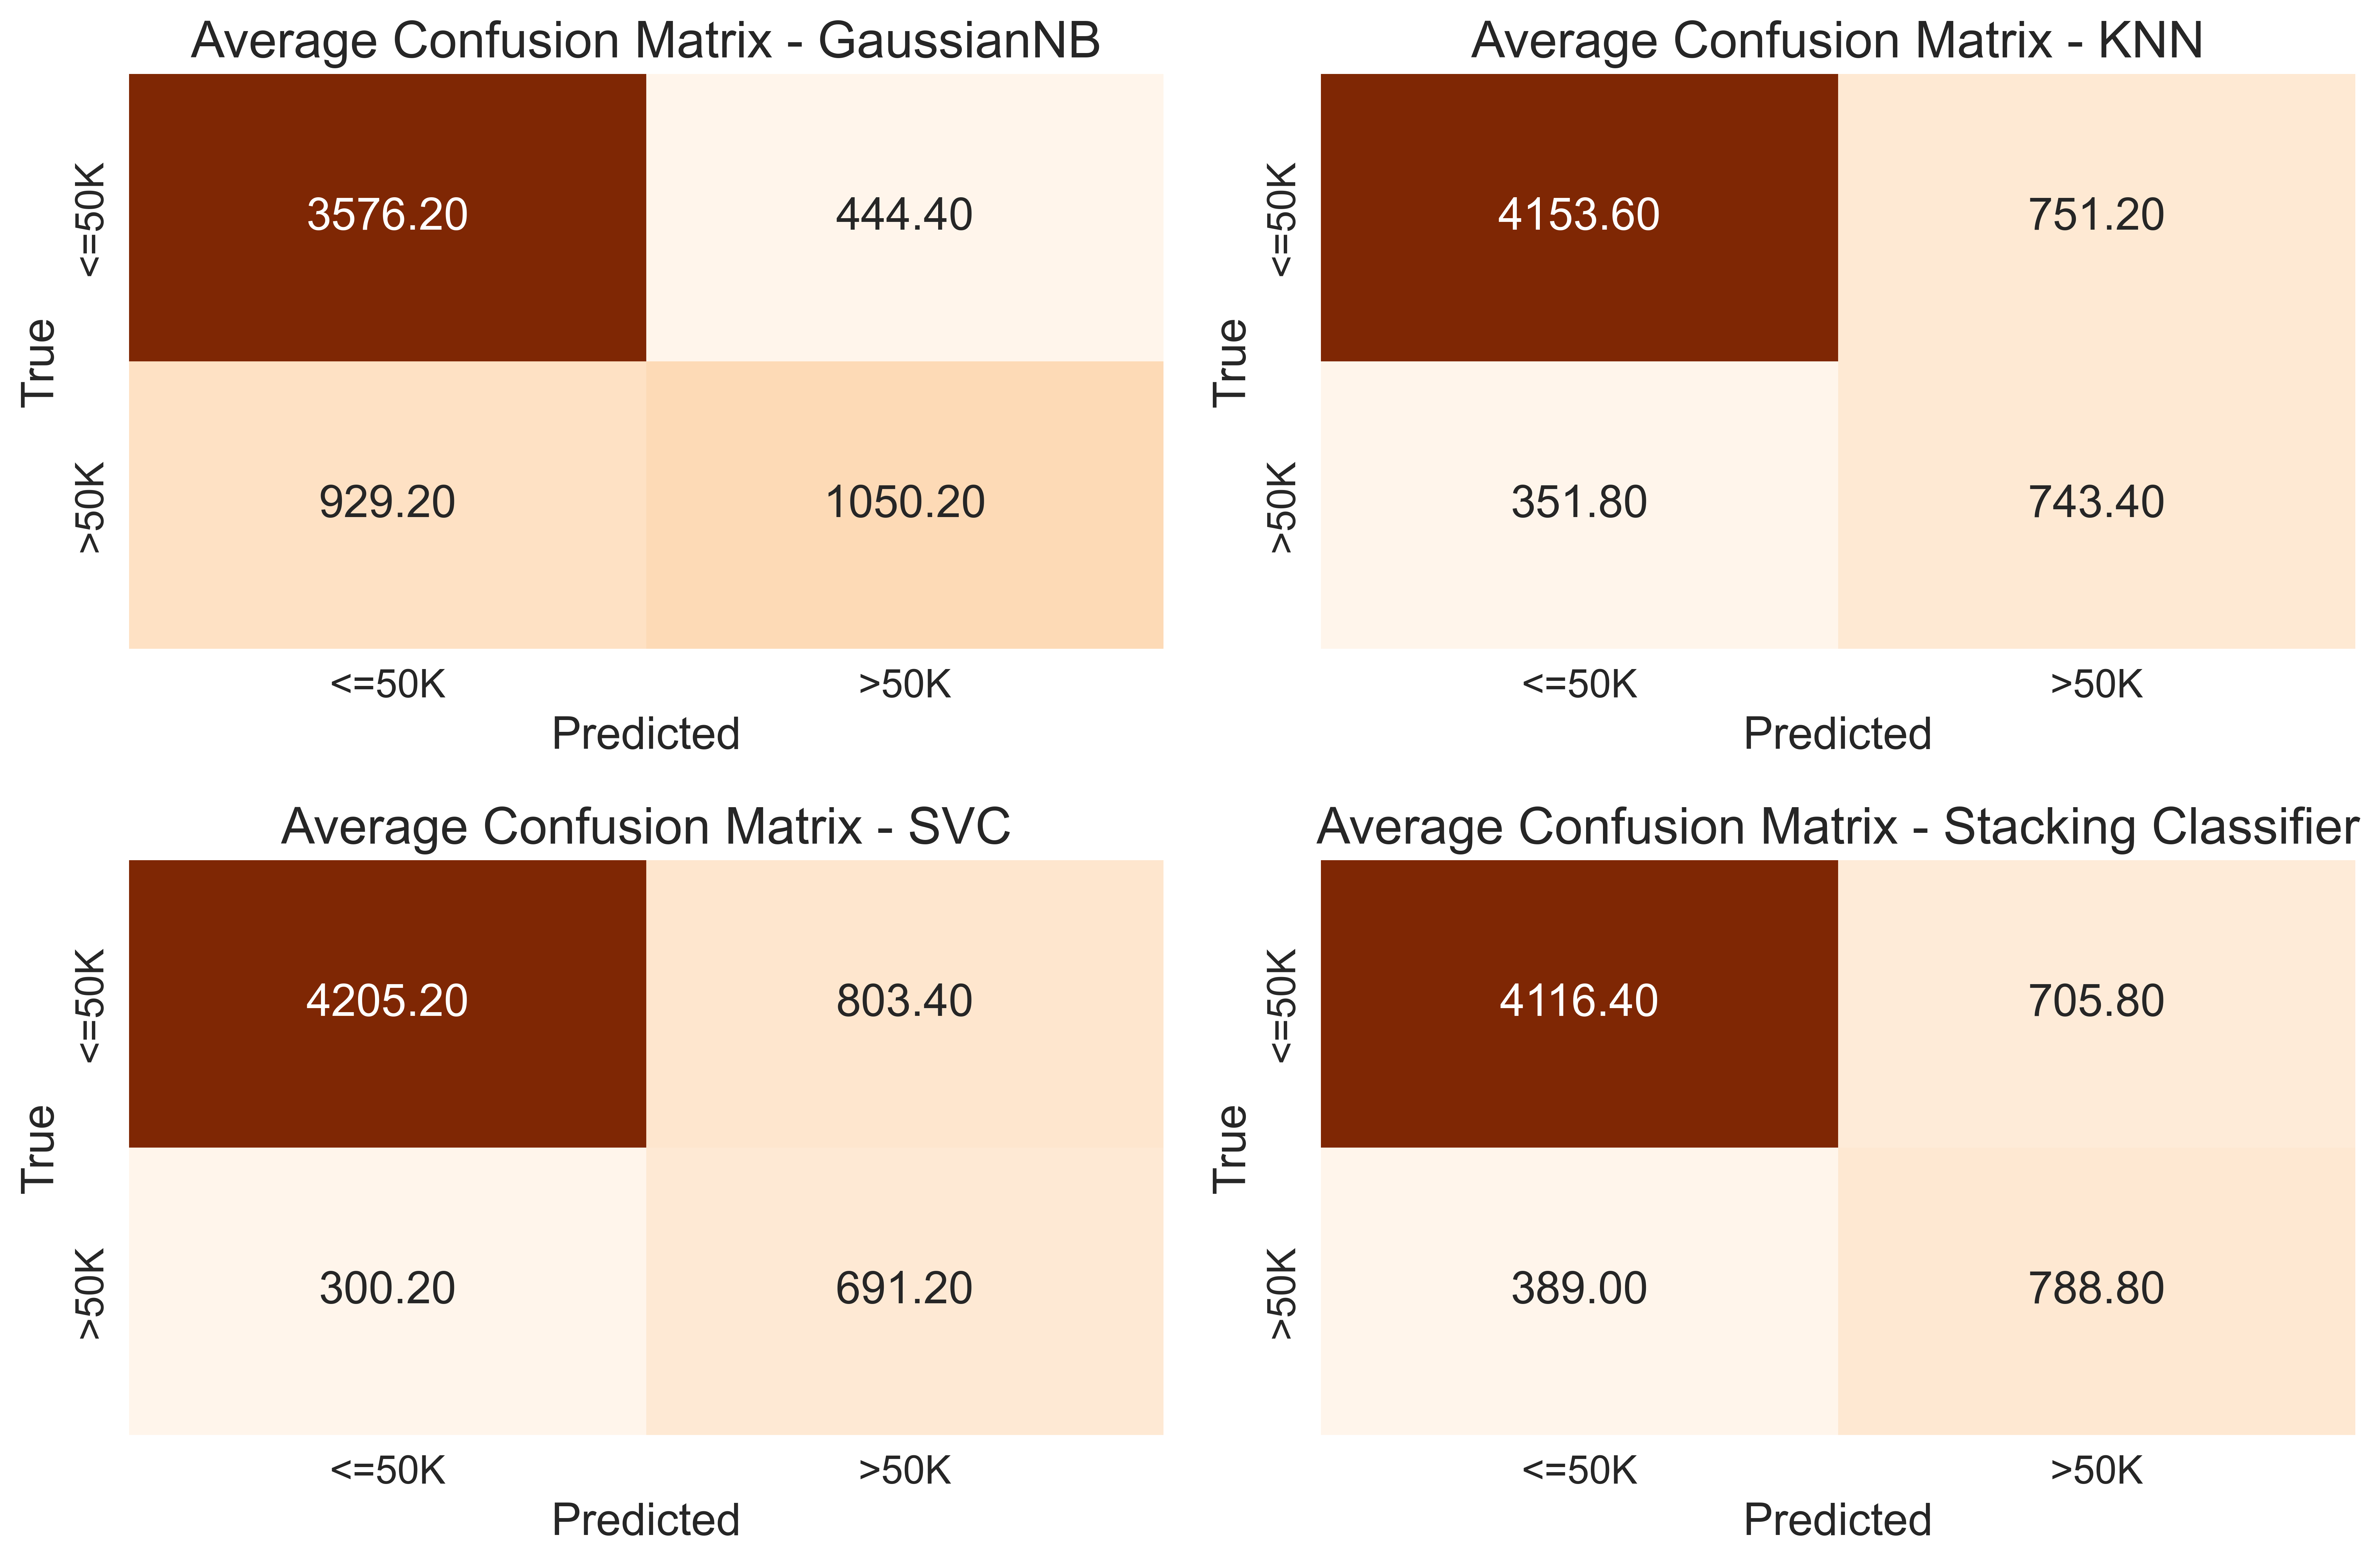

In [14]:
font_size = 16
plt.rcParams.update({
    'font.size': font_size,          # General font size
    'axes.titlesize': font_size + 2, # Title font size
    'axes.labelsize': font_size,     # Axis label font size
    'xtick.labelsize': font_size-2,    # X-tick label font size
    'ytick.labelsize': font_size-2     # Y-tick label font size
})
    
def plotComparativeMetrics(results):
    metrics_names = list(metrics.keys())
    metrics_names.append("Duration")
    
    num_metrics = len(metrics_names)
    num_plots_per_row = 3  # Number of plots per row
    num_rows = (num_metrics + 1) // num_plots_per_row  # Calculate the number of rows needed
    
    fig = plt.figure(figsize=(18, num_rows * 6), dpi=600)  # Create figure with specified DPI
    
    for i, metric_name in enumerate(metrics_names):
        ax = fig.add_subplot(num_rows, num_plots_per_row, i + 1)  # Add subplot to the figure
        for clf_name, clf_metrics in results.items():
            ax.plot(clf_metrics[metric_name], label=clf_name, marker='o')
        ax.set_title(metric_name)
        ax.set_xlabel("Iteration")
        ax.set_ylabel(metric_name)
        ax.legend()
        ax.grid(True)  # Optionally add grid lines
    
    plt.tight_layout()
    plt.show()
    
    
# def plotAverageConfusionMatrices(results):
#     num_classifiers = len(results)
#     num_plots_per_row = 2  # Number of plots per row
#     num_rows = (num_classifiers + 1) // num_plots_per_row  # Calculate the number of rows needed
#     
#     fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(12, num_rows * 4))  # Adjusted size
#     
#     # Flatten the axes array if there is only one row
#     if num_rows == 1:
#         axes = [axes]
#     
#     for i, (clf_name, clf_metrics) in enumerate(results.items()):
#         row_idx = i // num_plots_per_row
#         col_idx = i % num_plots_per_row
#         avg_conf_matrix = np.mean(clf_metrics["Confusion Matrix"], axis=0)
#         sns.heatmap(avg_conf_matrix, annot=True, cmap="Blues", fmt=".2f", cbar=False,
#                     xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"], ax=axes[row_idx, col_idx])
#         axes[row_idx, col_idx].set_xlabel('Predicted')
#         axes[row_idx, col_idx].set_ylabel('True')
#         axes[row_idx, col_idx].set_title(f'Average Confusion Matrix - {clf_name}')
# 
#     plt.tight_layout()
#     plt.show()

def plotAverageConfusionMatrices(results):
    num_classifiers = len(results)
    num_plots_per_row = 2  # Number of plots per row
    num_rows = (num_classifiers + 1) // num_plots_per_row  # Calculate the number of rows needed
    
    fig = plt.figure(figsize=(12, num_rows * 4), dpi=600)  # Create figure with specified DPI
    
    for i, (clf_name, clf_metrics) in enumerate(results.items()):
        ax = fig.add_subplot(num_rows, num_plots_per_row, i + 1)  # Add subplot to the figure
        avg_conf_matrix = np.mean(clf_metrics["Confusion Matrix"], axis=0)
        sns.heatmap(avg_conf_matrix, annot=True, cmap="Oranges", fmt=".2f", cbar=False,
                    xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"], ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        ax.set_title(f'Average Confusion Matrix - {clf_name}')
    
    plt.tight_layout()
    plt.show()

plotComparativeMetrics(results)
plotAverageConfusionMatrices(results)